## Dataset Analysis ##

In [25]:
# Setup and Configuration
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from collections import Counter
from tqdm import tqdm 

# --- CONFIGURATION ---
DATASET_NAME = "vggface2_raw/2gb/train"

PROJECT_DIR = Path().resolve().parent 
DATA_DIR = PROJECT_DIR / "datasets" / DATASET_NAME

print(f"Analyzing dataset: {DATA_DIR}")

if not DATA_DIR.exists():
    print(f"❌ ERROR: Folder {DATA_DIR} does not exist! Check DATASET_NAME.")
else:
    print(f"✅ Folder {DATA_DIR} found.")

Analyzing dataset: /home/kamil/pythong2/datasets/vggface2_raw/2gb/train
✅ Folder /home/kamil/pythong2/datasets/vggface2_raw/2gb/train found.


Indexing image files...
Found 176398 images.
Sampling 5000 images...
Starting verification...


100%|██████████| 5000/5000 [00:02<00:00, 2081.36it/s]



✅ No corrupted files found.

Dimension statistics:
Width: min=37, max=1082, avg=240.7
Height: min=43, max=1390, avg=257.4


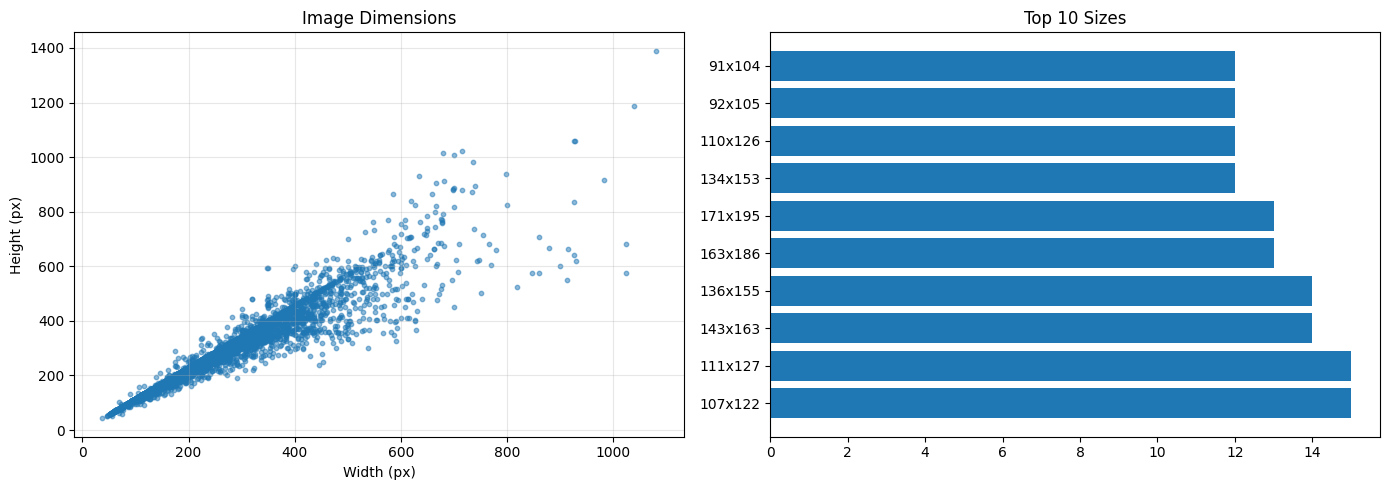

In [26]:
# Image size analysis & Integrity Check

SAMPLE_SIZE = 5000  # None = check all, 5000 = quick sample

print("Indexing image files...")
all_image_paths = []

for root, dirs, files in os.walk(DATA_DIR):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            all_image_paths.append(os.path.join(root, file))

total_images = len(all_image_paths)
print(f"Found {total_images} images.")

if total_images == 0:
    print("No images to analyze.")
else:
    if SAMPLE_SIZE and SAMPLE_SIZE < total_images:
        print(f"Sampling {SAMPLE_SIZE} images...")
        paths_to_check = random.sample(all_image_paths, SAMPLE_SIZE)
    else:
        print(f"Checking ALL {total_images} images...")
        paths_to_check = all_image_paths

    sizes = []
    corrupted_files = []

    print("Starting verification...")
    for img_path in tqdm(paths_to_check):
        try:
            with Image.open(img_path) as img:
                sizes.append(img.size)
                img.verify() 
        except Exception as e:
            corrupted_files.append(img_path)

    if corrupted_files:
        print(f"\n⚠️ FOUND {len(corrupted_files)} CORRUPTED FILES! (Examples: {corrupted_files[:3]})")
    else:
        print("\n✅ No corrupted files found.")

    if sizes:
        widths, heights = zip(*sizes)
        print(f"\nDimension statistics:")
        print(f"Width: min={min(widths)}, max={max(widths)}, avg={np.mean(widths):.1f}")
        print(f"Height: min={min(heights)}, max={max(heights)}, avg={np.mean(heights):.1f}")

        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        axes[0].scatter(widths, heights, alpha=0.5, s=10)
        axes[0].set_xlabel('Width (px)')
        axes[0].set_ylabel('Height (px)')
        axes[0].set_title('Image Dimensions')
        axes[0].grid(True, alpha=0.3)
        
        size_str = [f'{w}x{h}' for w, h in sizes]
        size_counts = Counter(size_str).most_common(10)
        labels, counts = zip(*size_counts)
        
        axes[1].barh(range(len(labels)), counts)
        axes[1].set_yticks(range(len(labels)))
        axes[1].set_yticklabels(labels)
        axes[1].set_title('Top 10 Sizes')
        
        plt.tight_layout()
        plt.show()

Processing 480 folders...


  0%|          | 0/480 [00:00<?, ?it/s]

100%|██████████| 480/480 [00:00<00:00, 3799.67it/s]


--- SUMMARY ---
Number of identities: 480
Total images: 176398
Average: 367.5 images/person
Min: 102 | Max: 720
Median: 369.0


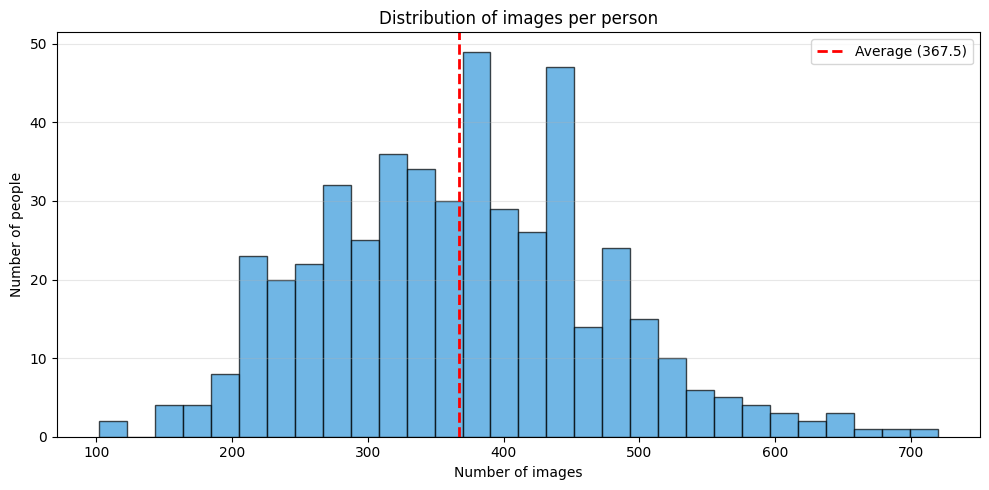

In [27]:
# Distribution of images per identity

if not DATA_DIR.exists():
    print("❌ Error: Folder does not exist.")
else:
    counts = []
    identities_list = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
    
    print(f"Processing {len(identities_list)} folders...")
    
    for identity in tqdm(identities_list):
        path = os.path.join(DATA_DIR, identity)
        n_images = len([f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        counts.append(n_images)

    if not counts:
        print("No data to analyze.")
    else:
        counts = np.array(counts)
        print(f"\n--- SUMMARY ---")
        print(f"Number of identities: {len(counts)}")
        print(f"Total images: {counts.sum()}")
        print(f"Average: {counts.mean():.1f} images/person")
        print(f"Min: {counts.min()} | Max: {counts.max()}")
        print(f"Median: {np.median(counts)}")

        plt.figure(figsize=(10, 5))
        plt.hist(counts, bins=30, color='#3498db', edgecolor='black', alpha=0.7)
        plt.axvline(counts.mean(), color='red', linestyle='dashed', linewidth=2, label=f'Average ({counts.mean():.1f})')
        
        plt.title('Distribution of images per person')
        plt.xlabel('Number of images')
        plt.ylabel('Number of people')
        plt.legend()
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

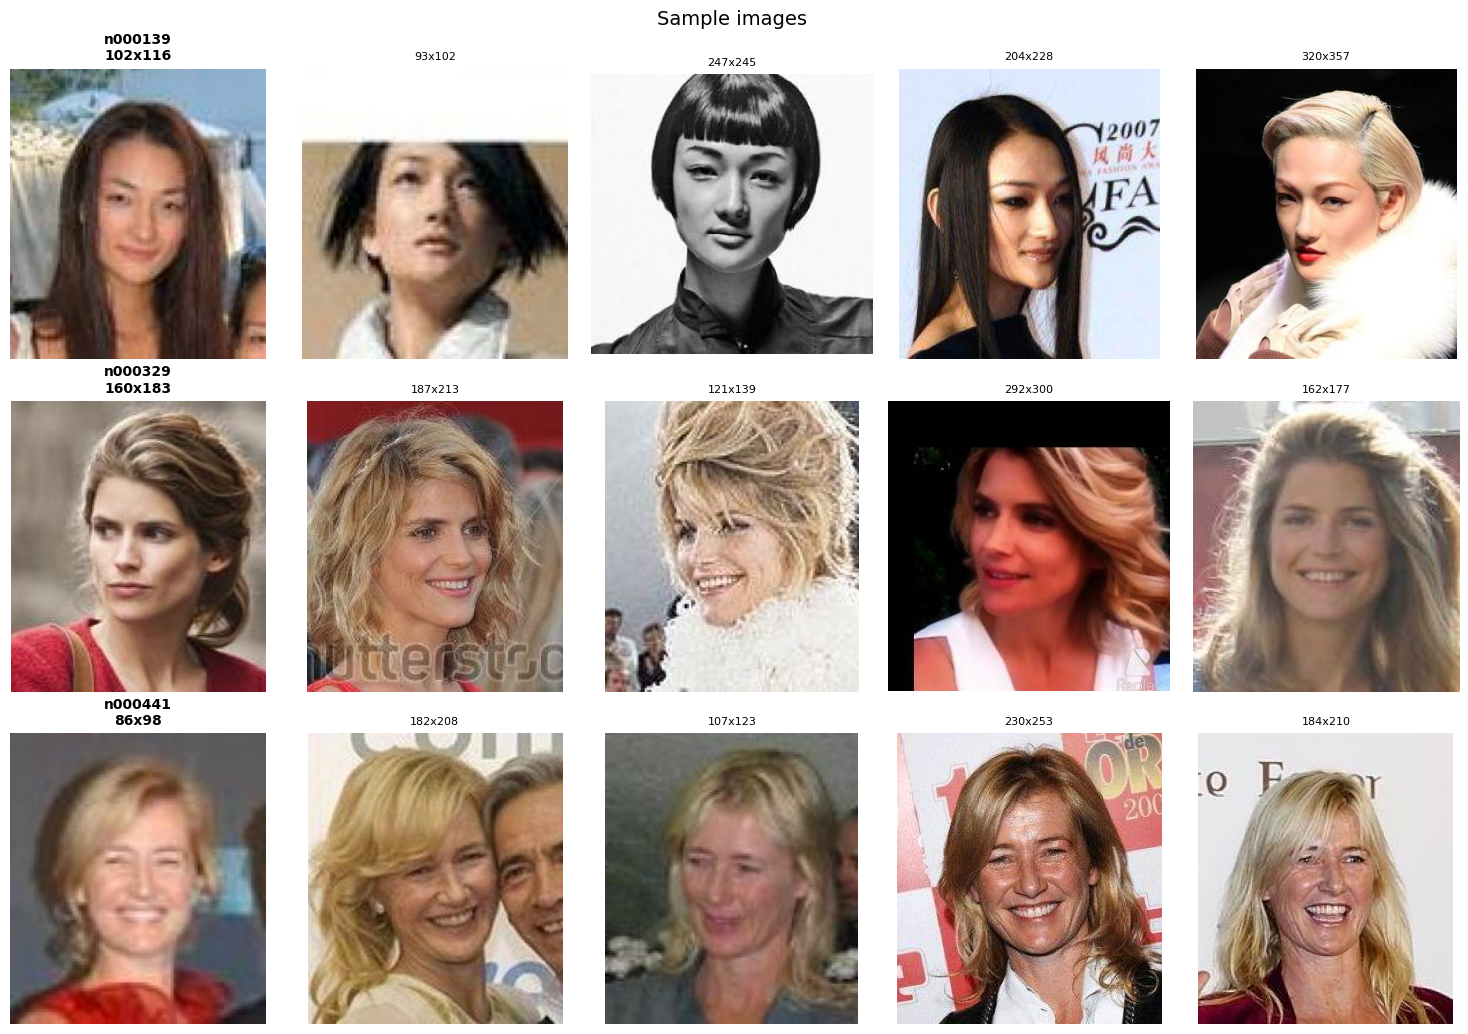

In [30]:
# Display sample images

identities = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])

if not identities:
    print("❌ Error: No identity folders found!")
else:
    num_samples = min(3, len(identities))
    sample_identities = random.sample(identities, num_samples)
    
    fig, axes = plt.subplots(num_samples, 5, figsize=(15, 3.5 * num_samples))
    
    if num_samples == 1: axes = np.array([axes]) 
    if len(axes.shape) == 1: axes = axes.reshape(num_samples, 5)

    for i, identity in enumerate(sample_identities):
        identity_path = os.path.join(DATA_DIR, identity)
        img_files = [f for f in os.listdir(identity_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:5]
        
        for j in range(5):
            ax = axes[i, j]
            ax.axis('off')
            
            if j < len(img_files):
                img_path = os.path.join(identity_path, img_files[j])
                try:
                    img = Image.open(img_path)
                    ax.imshow(img)
                    if j == 0:
                        ax.set_title(f'{identity}\n{img.size[0]}x{img.size[1]}', fontsize=10, fontweight='bold')
                    else:
                        ax.set_title(f'{img.size[0]}x{img.size[1]}', fontsize=8)
                except:
                    pass

    plt.suptitle('Sample images', fontsize=14)
    plt.tight_layout()
    plt.show()